In [9]:
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show
from interpret.perf import ROC

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics.pairwise import cosine_similarity
from typing import List
from sklearn.metrics import ndcg_score, average_precision_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

In [15]:
data_path = "../data/anime/"

# Read the dataset
animes = pd.read_csv(data_path + "anime.csv")
ratings = pd.read_csv(data_path + "rating.csv")

ratings = ratings.sample(1_000_000, random_state=42)

In [16]:
# 사용하는 피처만 남김
animes = animes[["anime_id", "type", "rating", "members", "name", "genre"]]
# 칼럼명 변경
animes.columns = ["anime_id", "type", "anime_total_rating", "members", "name", "genre"]
# 결측값이 포함된 애니는 drop
animes = animes.dropna()


# 평점 테이블도 동일하게 처리, 무효한 값은 제거 (rating이 -1인 값)
ratings = ratings[["user_id", "anime_id", "rating"]]
ratings = ratings[ratings["rating"] != -1]

# 데이터 프레임 join
data = ratings.merge(animes, on="anime_id", how="inner")

# 유저 정보가 없으므로, 유저의 평점 패턴에서 유저 피처 추출 (평균 평점 및 평점을 내린 수)
user_avg_rating = data.groupby("user_id")["rating"].mean().rename("User-AvgRating")
user_num_ratings = data.groupby("user_id")["rating"].count().rename("User-NumRatings")

# 추출한 유저 피처 결합
user_features = pd.concat([user_avg_rating, user_num_ratings], axis=1)

# 애니 메타 데이터에서 아이템 관련 피처 수가 생성
item_num_ratings = data.groupby("anime_id")["rating"].count().rename("Item-NumRatings")

# 애니 이름 피처에서 TF-IDF 피처 생성, 총 10개의 이름 생성 (most frequent 10 words)
tfidf_vectorizer = TfidfVectorizer(max_features=10)
item_name_tfidf = tfidf_vectorizer.fit_transform(animes["name"]).toarray()

tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

# 'type' 칼럼을 원핫 인코딩
onehot_encoder = OneHotEncoder(sparse=False)
item_type_onehot = onehot_encoder.fit_transform(animes[["type"]])

# TF-IDF 피처와 type 원핫 피처를 결합
tf_idf_df = pd.DataFrame(
    item_name_tfidf, columns=tfidf_feature_names, index=animes.anime_id
)
type_df = pd.DataFrame(
    item_type_onehot,
    columns=[f"Type-{cat}" for cat in onehot_encoder.categories_[0]],
    index=animes.anime_id,
)

animes_features = animes[["anime_id", "members", "anime_total_rating"]]


item_features = (
    pd.DataFrame(item_num_ratings)
    .merge(tf_idf_df, on="anime_id")
    .merge(type_df, on="anime_id")
    .merge(animes_features.set_index("anime_id"), on="anime_id")
)


# 인터렉션 데이터와 함께, user 및 item 피처 결합
data = data.drop(["anime_total_rating", "members"], axis=1)

data = data.join(user_features, on="user_id")
data = data.merge(item_features, on="anime_id")

# implicit feedback 표현을 위해 이진화 (유저의 평균 평점보다 높은 경우 1)
# 절대값으로 지정하는 방법도 있음
data["rating"] = (data["rating"] > data["User-AvgRating"]).astype(int)

# Train-test split
X = data.drop(columns=["user_id", "anime_id", "rating", "type", "name", "genre"])
y = data["rating"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

/opt/anaconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier

  0%|          | 0/2 [00:00<?, ?it/s]

Training LGBM with 1000 samples...
[LightGBM] [Info] Number of positive: 515, number of negative: 485
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000706 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1081
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.515000 -> initscore=0.060018
[LightGBM] [Info] Start training from score 0.060018


 50%|█████     | 1/2 [00:00<00:00,  1.10it/s]

LGBM AUC: 0.6622325077028113
Training EBM with 1000 samples...


100%|██████████| 2/2 [00:04<00:00,  2.07s/it]


EBM AUC: 0.7085381610279802


  0%|          | 0/2 [00:00<?, ?it/s]

Training LGBM with 10000 samples...
[LightGBM] [Info] Number of positive: 5099, number of negative: 4901
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000854 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1335
[LightGBM] [Info] Number of data points in the train set: 10000, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509900 -> initscore=0.039605
[LightGBM] [Info] Start training from score 0.039605


 50%|█████     | 1/2 [00:00<00:00,  1.50it/s]

LGBM AUC: 0.7388504851694132
Training EBM with 10000 samples...


100%|██████████| 2/2 [00:07<00:00,  3.81s/it]


EBM AUC: 0.7481111296090163


  0%|          | 0/2 [00:00<?, ?it/s]

Training LGBM with 100000 samples...
[LightGBM] [Info] Number of positive: 50622, number of negative: 49378
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002849 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1439
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506220 -> initscore=0.024881
[LightGBM] [Info] Start training from score 0.024881


 50%|█████     | 1/2 [00:01<00:01,  1.03s/it]

LGBM AUC: 0.7546555091491538
Training EBM with 100000 samples...


100%|██████████| 2/2 [01:00<00:00, 30.05s/it]

EBM AUC: 0.7558641189078126


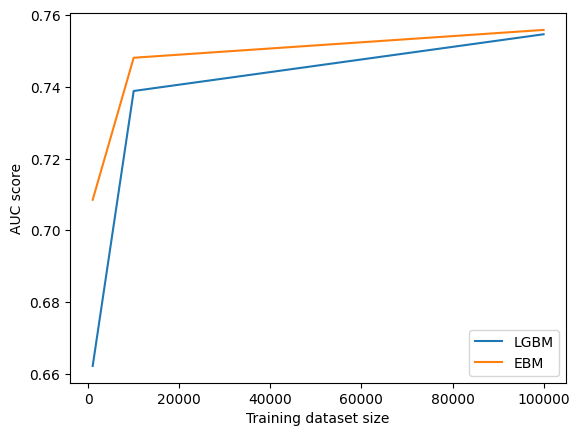

In [18]:
# 데이터셋 사이즈 지정
dataset_sizes = [1_000, 10_000, 100_000]

# 각 모델 별 auc score를 저장하기 위해 딕셔너리 정의
auc_scores = {model_name: [] for model_name in models.keys()}

# 각 모델 별 roc curve 정보 저장을 위해 딕셔너리 정의
roc_curves = {model_name: [] for model_name in models.keys()}

# 모델 정의
models = {
    "LGBM": LGBMClassifier(random_state=42),
    "EBM": ExplainableBoostingClassifier(random_state=42),
}

# 데이터 사이즈별로 iteration
for size in dataset_sizes:
    # 각 사이즈별로 데이터를 샘플링함
    X_train_sample = X_train.sample(n=size, random_state=42)
    y_train_sample = y_train.loc[X_train_sample.index]

    # 모델 별로 반복
    for model_name, model in tqdm(models.items()):
        print(f"Training {model_name} with {size} samples...")

        # 모델 적합
        model.fit(X_train_sample, y_train_sample)

        # 예측 결과 생성
        y_pred = model.predict_proba(X_test)[:, 1]

        # AUC 점수 계산
        auc_score = roc_auc_score(y_test, y_pred)
        auc_scores[model_name].append(auc_score)

        # ROC 곡선
        fpr, tpr, thresholds = roc_curve(y_test, y_pred)
        roc_curves[model_name].append((fpr, tpr))

        print(f"{model_name} AUC: {auc_score}")


# AUC 스코어 시각화
for model_name, model_auc_scores in auc_scores.items():
    plt.plot(dataset_sizes, model_auc_scores, label=model_name)
plt.xlabel("Training dataset size")
plt.ylabel("AUC score")
plt.legend()
plt.show()

In [19]:
%%time
# 100만개 기준 54분
# 10만개 기준 8분

# EBM 모델 인스턴스 생성
ebm = ExplainableBoostingClassifier(random_state=42)

# 모델 적합 
ebm.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
# 모델 성능 평가 -> ROC 기준
roc = ROC(ebm.predict_proba).explain_perf(X_test, y_test, name="ROC")
show(roc)